# Titanic - Classification Analysis

In [13]:
# Python Libraries
import math, io, os, sys, time, datetime, random, subprocess

In [14]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import missingno

# Feature Selection and Encoding

# Machine Learning
import catboost
from catboost import CatBoostClassifier, Pool, cv

# Metrics

# Managing warnings
import warnings
warnings.filterwarnings('ignore')

## Import dataset

In [15]:
# Load dataset
training_raw = pd.read_csv('./train.csv')
# test_raw = pd.read_csv('./test.csv')

In [16]:
# Join dataset
# data_raw = training_raw.append(test_raw).reset_index().drop('index', axis=1)

In [17]:
# Displaying the size of the Dataframe in Memory
def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("Bytes", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])
convert_size(training_raw.memory_usage().sum())


'83.66 KB'

## Data Exploration - Univariate

Univariate is simply explore one feature at a time.

In [18]:
# Describe numerical features
training_raw.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [19]:
# Describe categorical features
training_raw.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [20]:
# Quick look at our data
training_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


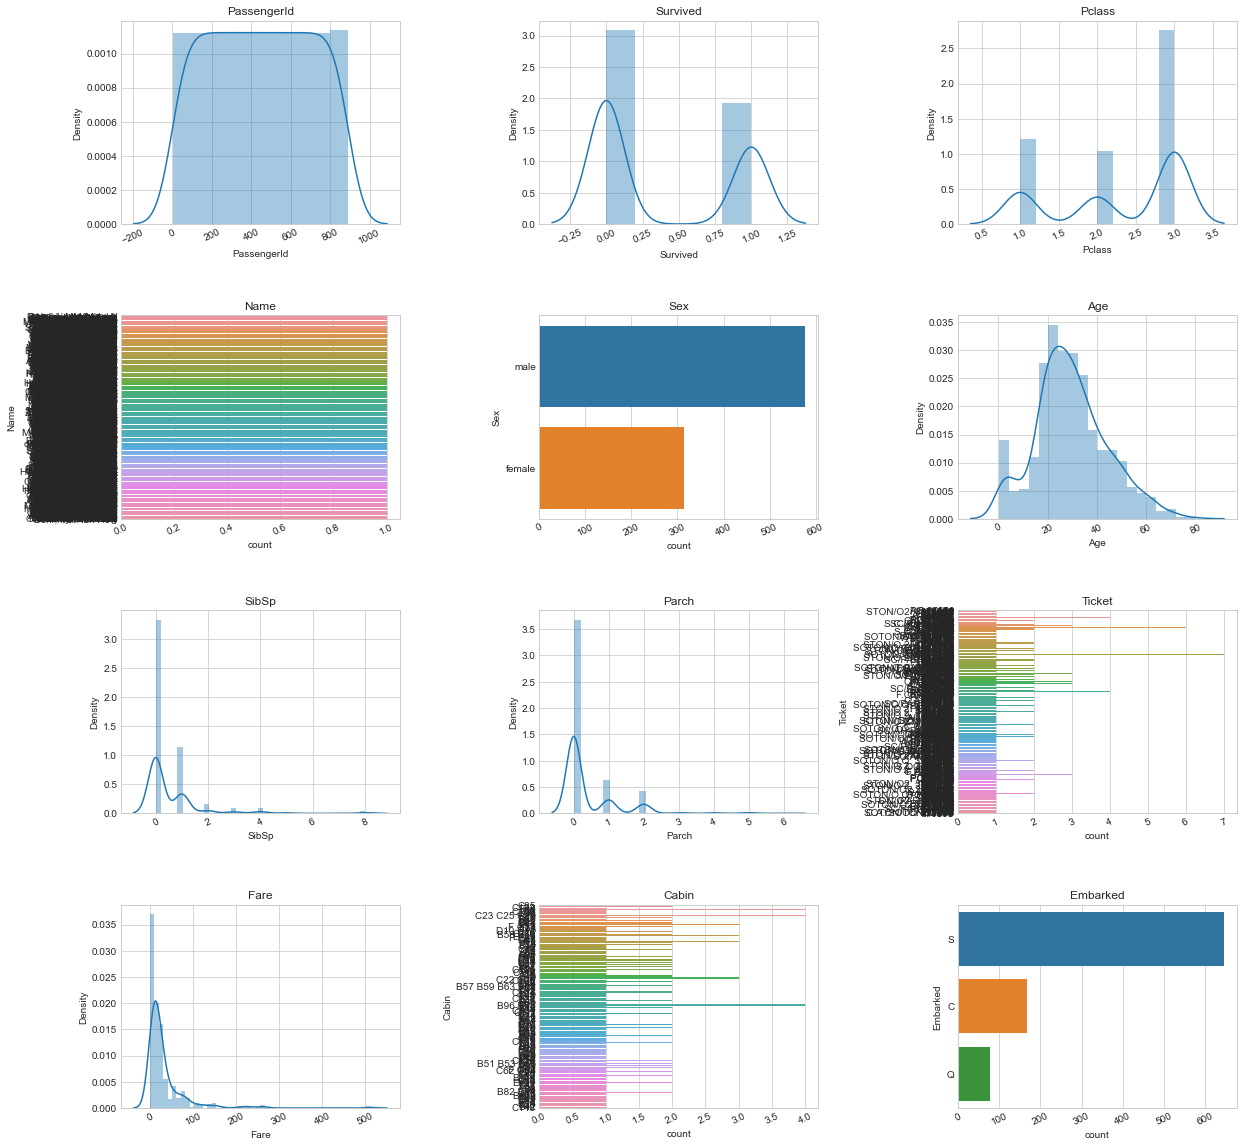

In [21]:
# Plot distribution of each feature
def plot_distribution(data, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(data.shape[1]) / cols)
    for i, column, in enumerate(data.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if data.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=data)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(data[column])
            plt.xticks(rotation=25)

plot_distribution(training_raw, cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

<AxesSubplot:>

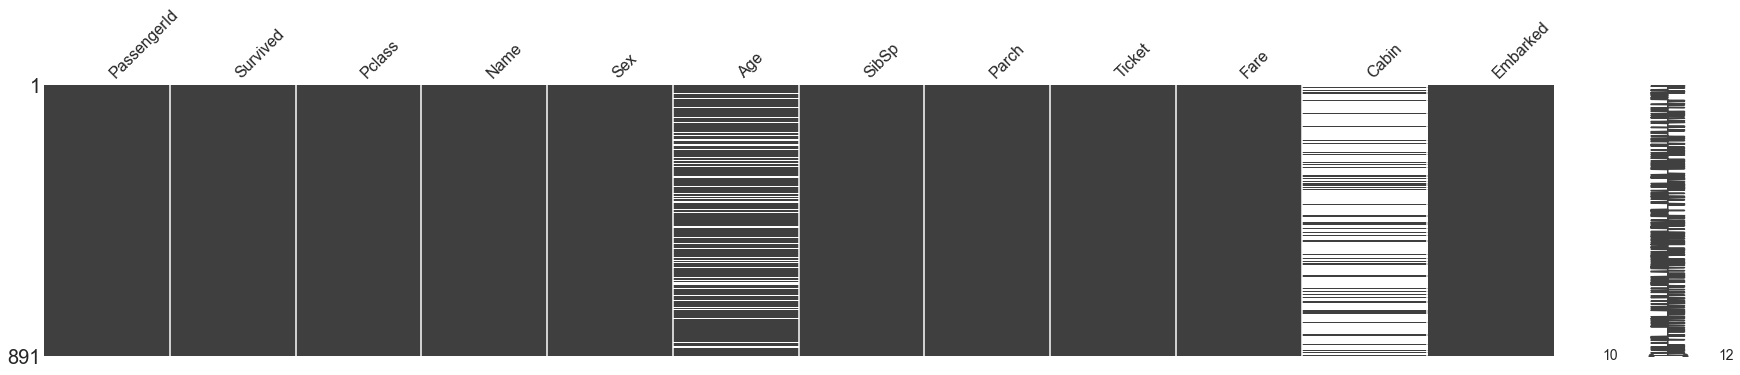

In [22]:
# Check for NA values
missingno.matrix(training_raw, figsize=(30, 5))

<AxesSubplot:>

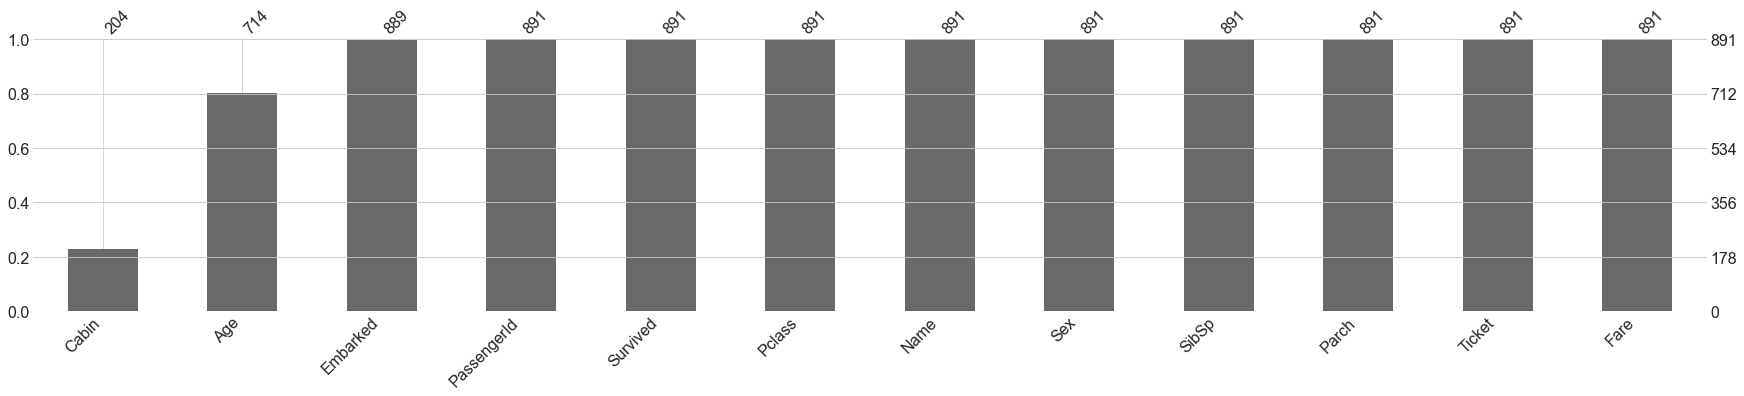

In [23]:
missingno.bar(training_raw, sort='ascending', figsize=(30, 5))

## Feature Cleaning, Engineering and Imputation

In [24]:
# To perform data analysis, we can create 2 new dataframes
data_bin = pd.DataFrame() # discretised continuous variables
data_con = pd.DataFrame() # continuous variables

### Feature: Survived

Whether the passenger survived or not.

`0`: Did not survive

`1`: Survived

0    549
1    342
Name: Survived, dtype: int64


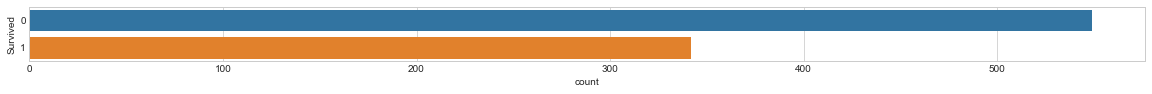

In [25]:
# How many people survived?
fig = plt.figure(figsize=(20, 1))
sns.countplot(y='Survived', data=training_raw);
print(training_raw.Survived.value_counts())

In [26]:
# Add to new dataframes
data_bin['Survived'] = training_raw['Survived']
data_con['Survived'] = training_raw['Survived']

In [27]:
data_bin.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [28]:
data_con.head()

,Survived
0,0
1,1
2,1
3,1
4,0


### Feature: Pclass

The ticket class of the passenger.

`1`: 1st

`2`: 2nd

`3`: 3rd

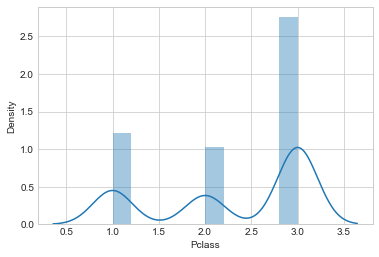

In [29]:
sns.distplot(training_raw.Pclass);

In [30]:
# Check for missing values for Pclass
training_raw.Pclass.isna().sum()

0

In [31]:
# Add to new dataframes
data_bin['Pclass'] = training_raw['Pclass']
data_con['Pclass'] = training_raw['Pclass']

### Feature: Name

The name of the passengers.

In [32]:
# How many different names are there?
len(training_raw.Name.value_counts().values)

891

There seems to be so many unique names, we won't be using it for this purpose.

### Feature: Sex

The sex of the passenger (male or female).

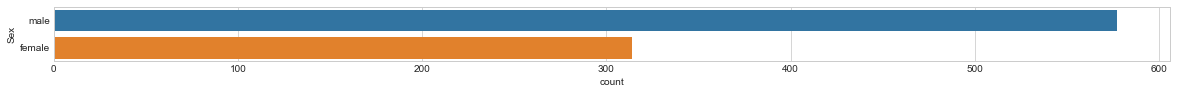

In [33]:
plt.figure(figsize=(20, 1))
sns.countplot(y='Sex', data=training_raw);

In [34]:
# Check for NA values for Sex
training_raw.Sex.isna().sum()

0

In [35]:
# Add to new dataframes
data_bin['Sex'] = training_raw['Sex']
data_bin['Sex'] = np.where(data_bin['Sex'] == 'female', 1, 0) # 0 for male, 1 for female

data_con['Sex'] = training_raw['Sex']

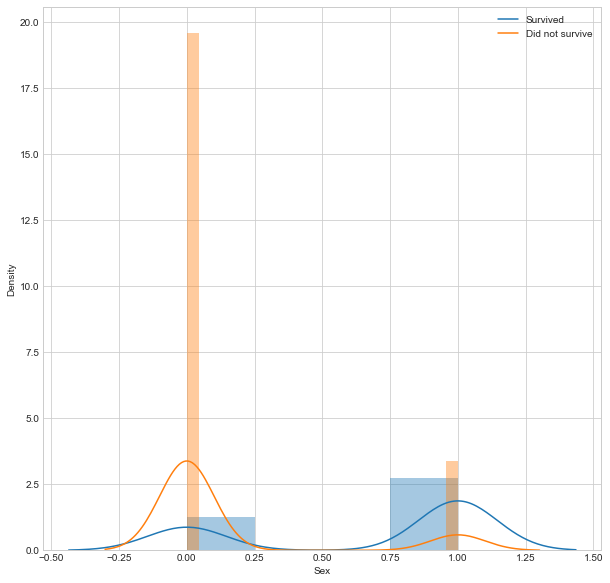

In [36]:
# Because Sex and Survived are binary values, let's plot them
fig = plt.figure(figsize=(10, 10))
sns.distplot(data_bin.loc[data_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'})
sns.distplot(data_bin.loc[data_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survive'})
plt.legend();

Not many people survived, but most of the survivors were female.

### Feature: Age

The age of the passengers.

In [37]:
# Check for NA values for Age
training_raw.Age.isna().sum()

177

### Feature: SibSp

The number of siblings/spouses the passenger has aboard the Titanic.

In [38]:
# Check for missing values
training_raw.SibSp.isna().sum()

0

In [39]:
# Check for values
training_raw.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [40]:
# Add to new dataframes
data_bin['SibSp'] = training_raw['SibSp']
data_con['SibSp'] = training_raw['SibSp']

In [41]:
def count_dist(data, bin_df, label_column, target_column, figsize=(20, 10), use_bin_df=False):
    if use_bin_df:
        fig = plt.figure(figsize=figsize)
        plt.subplot(121)
        sns.countplot(y=target_column, data=bin_df)
        plt.subplot(122)
        sns.distplot(data_bin.loc[data_bin[label_column] == 1][target_column], kde_kws={'label': 'Survived'})
        sns.distplot(data_bin.loc[data_bin[label_column] == 0][target_column], kde_kws={'label': 'Did not survive'})
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(121)
        sns.countplot(y=target_column, data=data)
        plt.subplot(122)
        sns.distplot(data_bin.loc[data_bin[label_column] == 1][target_column], kde_kws={'label': 'Survived'})
        sns.distplot(data_bin.loc[data_bin[label_column] == 0][target_column], kde_kws={'label': 'Did not survive'})

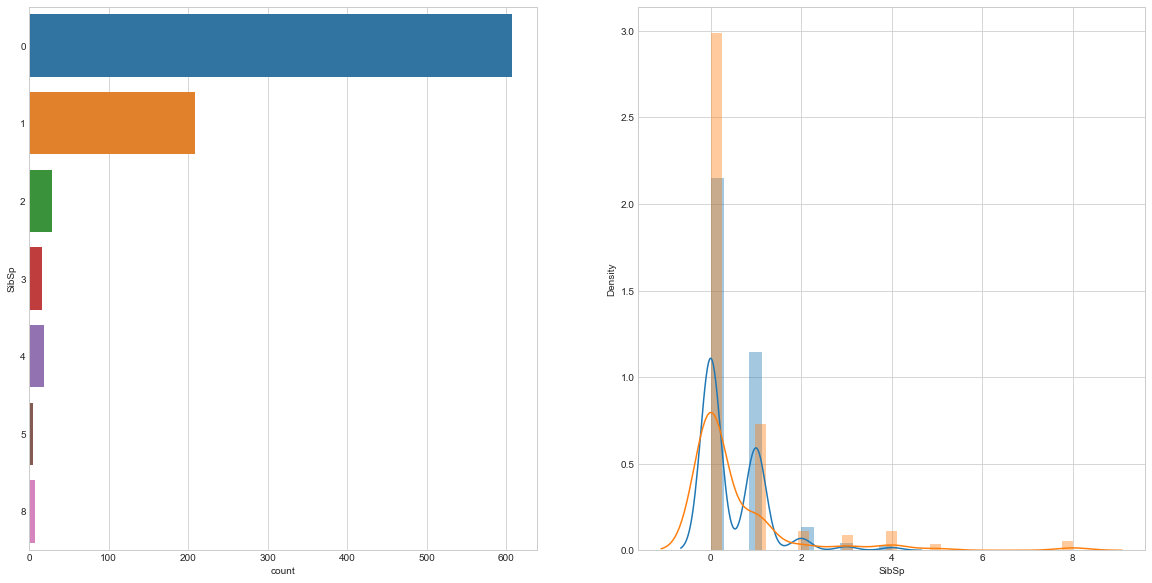

In [42]:
# Plot SibSp against Survived
count_dist(training_raw, bin_df=data_bin, label_column='Survived', target_column='SibSp', figsize=(20, 10))

### Feature: Parch

The number of parents/children the passenger has aboard the Titanic.

In [43]:
# Check for missing values
training_raw.Parch.isna().sum()

0

In [44]:
# Check for values
training_raw.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [45]:
# Add to new dataframes
data_bin['Parch'] = training_raw['Parch']
data_con['Parch'] = training_raw['Parch']

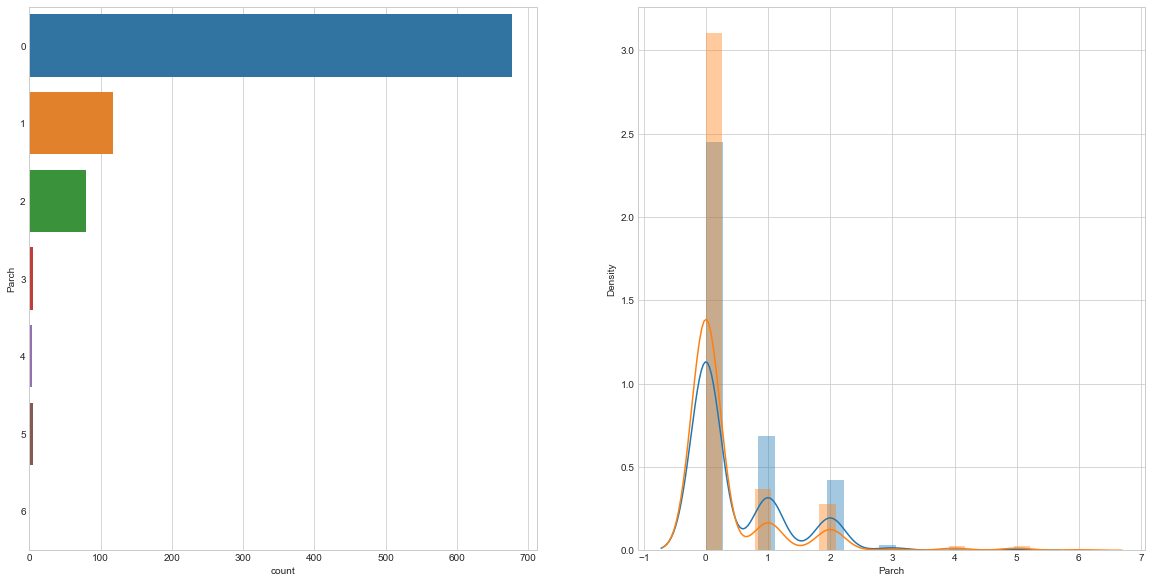

In [46]:
# Plot Parch against Survived
count_dist(training_raw, bin_df=data_bin, label_column='Survived', target_column='Parch', figsize=(20, 10))

### Feature: Ticket

In [47]:
# Check for missing values
training_raw.Ticket.isna().sum()

0

<AxesSubplot:xlabel='count', ylabel='Ticket'>

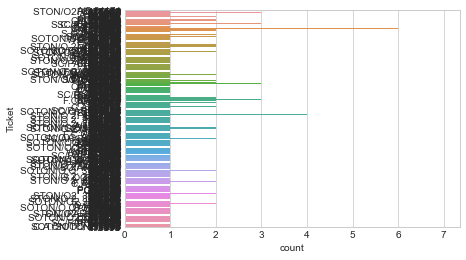

In [48]:
# Check for ticket unique values
sns.countplot(y="Ticket", data=training_raw)

In [49]:
len(training_raw.Ticket.value_counts().values)

681

That is too much, we won't be using it in our analysis.

### Feature: Fare

The price of the tickets.

In [50]:
# Check for missing values
training_raw.Fare.isna().sum()

0

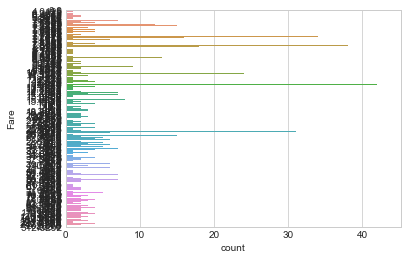

In [51]:
# Check for ticket unique values
sns.countplot(y="Fare", data=training_raw);

In [52]:
# Check for Fare dtype
training_raw.Fare.dtype

dtype('float64')

In [53]:
len(training_raw.Fare.value_counts().values)

248

Since Fare is a float, we will add it to our continuous sub dataframe.

To add it to categorical sub dataframe, we can use `pd.cut`.

In [54]:
# Add to new dataframes
data_bin['Fare'] = pd.cut(training_raw['Fare'], bins=5)
data_con['Fare'] = training_raw['Fare']

In [55]:
# Fare values after cutting
data_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

### Feature: Cabin

The cabin number where the passenger was staying.

In [56]:
# Check for missing values
training_raw.Cabin.isna().sum()

687

Woah, there are too many missing values, in that case, I don't think we will be using Cabin as a feature.

### Feature: Embarked

The port where the passenger boarded the Titanic.

In [57]:
# Check for missing values
training_raw.Embarked.isna().sum()

2

In [58]:
# Check for values
training_raw.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

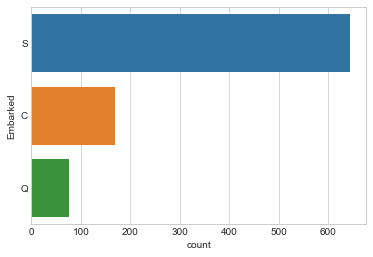

In [59]:
# Check for Embarked counts unique values
sns.countplot(y="Embarked", data=training_raw);

In [60]:
# Add to new dataframes
data_bin['Embarked'] = training_raw['Embarked']
data_con['Embarked'] = training_raw['Embarked']

In [61]:
# For now we will remove the 2 rows that has an NA value
print(len(data_con))
data_con = data_con.dropna(subset=['Embarked'])
data_bin = data_bin.dropna(subset=['Embarked'])
print(len(data_con))

891
889


### Feature Encoding

Now we have our two sub dataframes ready. We can encode the features so they are ready to be used with our machine learning models.

We will encode `data_bin` with one-hot encoding, and `data_con` with label encoding.

> Can also use one-hot encoding for `data_con`.

In [62]:
data_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,"(-0.512, 102.466]",S
1,1,1,1,1,0,"(-0.512, 102.466]",C
2,1,3,1,0,0,"(-0.512, 102.466]",S
3,1,1,1,1,0,"(-0.512, 102.466]",S
4,0,3,0,0,0,"(-0.512, 102.466]",S


In [63]:
# One-hot encoding data_bin
one_hot_cols = data_bin.columns.tolist().remove('Survived') # Survive is the classification label (no need to one-hot encode it)
data_bin_enc = pd.get_dummies(data_bin, columns=one_hot_cols)
data_bin_enc.head()

,Survived,Pclass,Sex,SibSp,Parch,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,1,0,1,0,0,0,0,0,0,1
1,1,1,1,1,0,1,0,0,0,0,1,0,0
2,1,3,1,0,0,1,0,0,0,0,0,0,1
3,1,1,1,1,0,1,0,0,0,0,0,0,1
4,0,3,0,0,0,1,0,0,0,0,0,0,1


In [64]:
data_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S


In [65]:
# Using One-Hot Encoding for data_con
data_embarked_one_hot = pd.get_dummies(data_con.Embarked, prefix='embarked')
data_sex_one_hot = pd.get_dummies(data_con.Sex, prefix='sex')
data_pclass_one_hot = pd.get_dummies(data_con.Pclass, prefix='pclass')

In [66]:
# Combine to one dataframe
data_con_enc = pd.concat([data_con, data_embarked_one_hot, data_sex_one_hot, data_pclass_one_hot], axis=1)

In [67]:
# Drop original categorical columns
data_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1, inplace=True)

In [68]:
data_con_enc.head()

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1


## Modeling

In [69]:
X = data_con_enc.drop('Survived', axis=1)
y = data_con_enc['Survived']

In [70]:
from sklearn.model_selection import train_test_split

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [71]:
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)

rf = RandomForestClassifier().fit(X_train, y_train)
rf.score(X_test, y_test)

0.7584269662921348

In [72]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier().fit(X_train, y_train)
knn.score(X_test, y_test)

0.7752808988764045

In [73]:
from sklearn.linear_model import LogisticRegression

np.random.seed(42)

lr = LogisticRegression().fit(X_train, y_train)
lr.score(X_test, y_test)

0.7808988764044944

In [74]:
from sklearn.svm import SVC

np.random.seed(42)

svc = SVC().fit(X_train, y_train)
svc.score(X_test, y_test)

0.6797752808988764

In [75]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier().fit(X_train, y_train)
dt.score(X_test, y_test)

0.7865168539325843

In [76]:
from sklearn.ensemble import GradientBoostingClassifier

np.random.seed(42)

gb = GradientBoostingClassifier().fit(X_train, y_train)
gb.score(X_test, y_test)

0.797752808988764

### CatBoost

In [78]:
# Define categorical features for CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10])

This means CatBoost has picked up that all variables except `Fare` can be treated as categorical.

In [79]:
# Use Pool() to pool togethere training data and categorical feature labels
train_pool = Pool(X_train, y_train, cat_features)

In [ ]:
# Create CatBoost model
cb = CatBoostClassifier(iterations=1000, custom_loss=['Accuracy'], loss_function='Logloss')

# Fit
cb.fit(train_pool, plot=True)

# Show accuracy
acc_cb = round(cb.score(X_train, y_train) * 100, 2)

In [ ]:
# Cross-validation with CatBoost
cv_params = cb.get_params()

# Cross-validation for 10-folds
cv_data = cv(train_pool, cv_params, fold_count=10, plot=True)

# Show cv accuracy
acc_cv_cb = round(np.max(cv_data['test-Accuracy-mean'] * 100), 2)

In [87]:
# Show CatBoost metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_cb))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_cb))


---CatBoost Metrics---
Accuracy: 84.95
Accuracy cross-validation 10-Fold: 82.85


In [116]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = cb.eval_metrics(train_pool, metrics=metrics)

print("---CatBoost Metrics---")
for metric in metrics:
    print(f"{str(metric)}: {np.mean(eval_metrics[metric])}")

---CatBoost Metrics---
Precision: 0.8441037619271895
Recall: 0.696239852398524
F1: 0.7628215213443877
AUC: 0.8920276794699764


## Feature Importance

To see which features were most important for making predictions.

In [108]:
rf.feature_importances_

array([0.0694035 , 0.06900983, 0.371942  , 0.01896322, 0.00794994,
       0.01792192, 0.14995041, 0.17761279, 0.02875743, 0.01695991,
       0.07152905])

In [111]:
feature_importance = dict(zip(X_train.columns, list(rf.feature_importances_)))
feature_importance

{'SibSp': 0.06940349760105265,
 'Parch': 0.06900983033904262,
 'Fare': 0.3719420044542379,
 'embarked_C': 0.018963219782325028,
 'embarked_Q': 0.007949936600247086,
 'embarked_S': 0.017921924924033026,
 'sex_female': 0.14995040621082684,
 'sex_male': 0.1776127914664238,
 'pclass_1': 0.028757431548050928,
 'pclass_2': 0.01695990949677361,
 'pclass_3': 0.0715290475769865}

<AxesSubplot:title={'center':'Feature Importance'}>

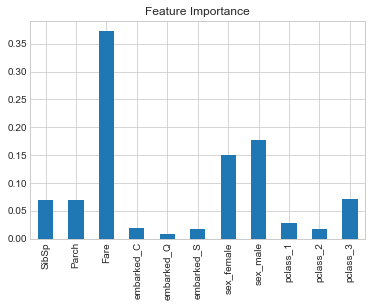

In [112]:
feature_df = pd.DataFrame(feature_importance, index=[0])
feature_df.T.plot.bar(title="Feature Importance", legend=False)

## Predicting on test dataset

In [97]:
# We should make our test dataset look like this
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
708,0,0,151.5500,0,0,1,1,0,1,0,0
240,1,0,14.4542,1,0,0,1,0,0,0,1
382,0,0,7.9250,0,0,1,0,1,0,0,1
792,8,2,69.5500,0,0,1,1,0,0,0,1
683,5,2,46.9000,0,0,1,0,1,0,0,1


In [98]:
test_raw = pd.read_csv('./test.csv')
test_raw.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [99]:
# Using One-Hot Encoding for data_con
test_embarked_one_hot = pd.get_dummies(test_raw.Embarked, prefix='embarked')
test_sex_one_hot = pd.get_dummies(test_raw.Sex, prefix='sex')
test_pclass_one_hot = pd.get_dummies(test_raw.Pclass, prefix='pclass')

In [100]:
# Combine
test = pd.concat([test_raw, test_embarked_one_hot, test_pclass_one_hot, test_sex_one_hot], axis=1)

In [101]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,embarked_C,embarked_Q,embarked_S,pclass_1,pclass_2,pclass_3,sex_female,sex_male
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,1,0,0,0,1,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,1,0,0,1,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,1,0,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0,1,0,0,1,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,0,1,0,0,1,1,0


In [102]:
# Create a list of columns to be used for prediction
list_test_col = X_train.columns
list_test_col

Index(['SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S',
       'sex_female', 'sex_male', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [103]:
test[list_test_col]

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,0,7.8292,0,1,0,0,1,0,0,1
1,1,0,7.0000,0,0,1,1,0,0,0,1
2,0,0,9.6875,0,1,0,0,1,0,1,0
3,0,0,8.6625,0,0,1,0,1,0,0,1
4,1,1,12.2875,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
413,0,0,8.0500,0,0,1,0,1,0,0,1
414,0,0,108.9000,1,0,0,1,0,1,0,0
415,0,0,7.2500,0,0,1,0,1,0,0,1
416,0,0,8.0500,0,0,1,0,1,0,0,1


In [104]:
# Predict using CatBoost algorithm
predictions = cb.predict(test[list_test_col])
predictions[:5]

array([0, 0, 0, 0, 1])

In [106]:
# Create submission dataframe
submit = pd.DataFrame()
submit['PassengerId'] = test_raw['PassengerId']
submit['Survived'] = predictions.astype(int)
submit.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [107]:
submit.to_csv('submission_catboost.csv', index=False)